# Regularization in Deep Learning

-------

ENGG 192 <br>
Dartmouth College - January 25, 2019 <br>
Spencer Bertsch

In this notebook I will discuss several techniques for regularization and ways of improving deep learning models. 

I discuss how random search is a better method for hyperparameter optimization than manual or grid search. I also discuss other methods of regularization such as L1 and L2 regularization, early stopping, and dropout layers. 

I end by discussing methods for automated hyperparameter tuning (i.e. AutoKeras)

In addition to discussing the differences between these techniques and the specific use cases for each, I will apply some of them on a real world example to see how they work on an example dataset. I found a fun dataset for this notebook: the data provides a numerical description of many different types of mushrooms and the binary label vector shows whether or not the mushroom is poisonous. 

The goal of the model is to approximate f*(x), a model which can use a muchroom's growing location and other characteristics to determine whether or not it's poisonous. I chose this dataset for several reasons, one being its size. Becasue it's relatively small, it will lend itself to quick training and testing. 

The data source for this notebook is the [Mushroom Classification](https://www.kaggle.com/uciml/mushroom-classification) which is held by Kaggle. 

Other sources for this notebook are discussed in the "Deep Learning" sections below, but some of the larger sources include: 

[Sung Kim's Github](https://github.com/hunkim) <br>
[Stanford PyTorch Github](https://cs230-stanford.github.io/pytorch-getting-started.html)

"Deep Learning" by Ian Goodfellow and Yoshua Bengio and Aaron Courville. 

@book{Goodfellow-et-al-2016, <br>
    title={Deep Learning}, <br>
    author={Ian Goodfellow and Yoshua Bengio and Aaron Courville}, <br>
    publisher={MIT Press}, <br>
    note={\url{http://www.deeplearningbook.org}}, <br>
    year={2016} <br>
}




## Imports

In [368]:
# Deep learning 
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable #<-- Variable can be thought of as a Torch matrix
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math

#Data cleaning and preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#Model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import f1_score

## Load the Dataset 

Our dataset exists as a .csv file downloaded form Kaggle. In a more developed project we could implement a more efficient way for data to be loaded into the notebook, but for now we can simply use a handy feature of Pandas called 'read_csv' to import a .csv to a pandas dataframe. 

In [369]:
# Import the dataset - load .csv file
path = '/Users/spencerbertsch/Desktop/ENGG 192/Regularization/Data/mushrooms.csv'
#create a dataframe from the Audit data stored in the .csv file
data_raw = pd.read_csv(path)

print("Shapw of raw dataset:", (data_raw.shape))
print("So we can see that we have" , (data_raw.shape[1] - 1) , "features and one label vector")
print("We can also see that we have", data_raw.shape[0] , "rows")
print(" ")
print("We can also preview our dataset by observing the top five rows")
data_raw.head(5)


Shapw of raw dataset: (8124, 23)
So we can see that we have 22 features and one label vector
We can also see that we have 8124 rows
 
We can also preview our dataset by observing the top five rows


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## Data Cleaning 

Our data is currently in the form of letters.. Let's clean this up using integer encoding. 

In [370]:
#define a function to label encode a 2D (x,y) matrix and return an encoded matrix
def int_encode(df):
    cols = df.shape[1]
    rows = df.shape[0]
    original_size = df.shape[1]
    
    for i in range(0, cols, 1):
        values = df.iloc[:,i]
        #integer encode each column
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(values) #integer encode the i'th column 
        encoded_vec = pd.DataFrame(integer_encoded) #convert to pd.dataframe
        df = pd.concat([df, encoded_vec], axis=1) #concatenate the new, encoded vector onto the original dataframe
    
    final_df = df.iloc[:,-cols:] #Only keep the last (leftmost) half of the columns representing the encoded data
    print("Integer encoding successful!")
    print("Dataframe shape: ", final_df.shape)
    return(final_df)

In [371]:
df = int_encode(data_raw)
df.head(5) #preview our new dataset

Integer encoding successful!
Dataframe shape:  (8124, 23)


,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


## Scaling

We can now scale our dataset. Becasue our data is already numerical, there's no need for any type of encoding. This means we can jump right in and use a handy Sklearn scaling package to scale our training data. 

In [372]:
#Scaling #<-- Comment out for now 
# df_scaled = preprocessing.scale(df2)
# print(df_scaled[:,5:]) #print first 5 rows of the new numpy matrix

## Split our dataset

And with that, we're ready to split our data into a training and testing set. It would also be helpful to hold out a piece of the data for validation, but becasue we're just focusing on regularization processes, we don't need a validation section. 

In [373]:
#Seperate training and testing data
y = df.iloc[:, 0] #labels are the first column in the matrix
X = df.iloc[:, -22:] #assign feature set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print("X train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)
print("X test shape: ", X_test.shape)
print("y test shape: ", y_test.shape) 

#Later when we convert to torch tensors, we will need our data to exist as numpy arrays, not pandas arrays 
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values 
y_test = y_test.values

X train shape:  (5686, 22)
y train shape:  (5686,)
X test shape:  (2438, 22)
y test shape:  (2438,)


# Keras - TF Backend

------

In addition to using PyTorch (which I prefer becasue it gives you more control over feedofrward networks than using the Keras API on a ;ibrary such as TensorFlow or Theano), I will use Keras with a TensorFlow backend simply as a benchmark. Although there's less control using Keras and Tensorflow, it's very easy to set up a quick feedforward neural network using the 

In [374]:
# Additional imports 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [375]:
# We can simply generate a 'sequential' model in Keras which will provide us with a simple, dense, fully connected neural network
model = Sequential()
model.add(Dense(10, activation='relu', input_dim=22))
model.add(Dense(units = 10, activation='relu'))
model.add(Dense(units = 10, activation='relu'))
model.add(Dense(units = 10, activation='relu'))
model.add(Dense(units = 10, activation='relu'))
model.add(Dense(units = 1, activation='sigmoid')) 
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [376]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=100)#<-- Given the size of our dataset, we could definitely reduce batch size 

Epoch 1/10
5686/5686 [==============================] - 1s 210us/step - loss: 0.7308 - acc: 0.4993
Epoch 2/10
5686/5686 [==============================] - 0s 21us/step - loss: 0.5840 - acc: 0.6885
Epoch 3/10
5686/5686 [==============================] - 0s 21us/step - loss: 0.4327 - acc: 0.8240
Epoch 4/10
5686/5686 [==============================] - 0s 23us/step - loss: 0.3048 - acc: 0.8845
Epoch 5/10
5686/5686 [==============================] - 0s 20us/step - loss: 0.2569 - acc: 0.9091
Epoch 6/10
5686/5686 [==============================] - 0s 19us/step - loss: 0.2331 - acc: 0.9223

In [377]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred>0.5,1,0) #Convert to binary
y_true = y_test
Acc = accuracy_score(y_true, y_pred)
F1 = f1_score(y_true, y_pred)
print("Accuracy: ", Acc)
print("F1 Score: ", F1)

Accuracy:  0.9392945036915504
F1 Score:  0.9356521739130435


Interesting to note here that with a simple "Sequential" net implemented in Keras, we can quickly achieve a ~93% accuracy and a ~93% F1 score. If we let the network train for more epochs, then we can easily push our performance even higher. However, our goal for this notebook is not to achieve the best model performance, but rather to develop an applied understanding of regularization - both practical and theoretical.

# Deep Learning - PyTorch

------

### SOURCES

When learning how to construct feedforward networks (or any type of netowrk) in PyTorch, I referenced [Sung Kim's Github](https://github.com/hunkim). There, Sung Kim has layed out a repository called [PyTorch Zero To All](https://github.com/hunkim/PyTorchZeroToAll) in which he includes slide decks and code explaining how to build neural netowrks using pytorch from first principles. This was my main resource - in addition to Sung Kim's [Youtube Series](https://www.youtube.com/watch?v=SKq-pmkekTk) - which I used for the next section of this notebook. 

Another source which I have started to use when constructing networks in PyTorch is [a Stanford Github](https://cs230-stanford.github.io/pytorch-getting-started.html) account which outlines best practices for developing clean, well functioning netowrks in PyTorch. 

Other important sources include: 

"Deep Learning" by Ian Goodfellow and Yoshua Bengio and Aaron Courville. 

@book{Goodfellow-et-al-2016, <br>
    title={Deep Learning}, <br>
    author={Ian Goodfellow and Yoshua Bengio and Aaron Courville}, <br>
    publisher={MIT Press}, <br>
    note={\url{http://www.deeplearningbook.org}}, <br>
    year={2016} <br>
}

In [378]:
#Define Network

class Mushroom_Net(nn.Module):
    def __init__(self):
        """
        "super can be used to refer to parent classes without naming them explicitly"
        
        We can now construct the network using torch.nn.linear layers 
        """
        super().__init__()
        self.l1 = torch.nn.Linear(22, 12)
        #self.dropout = nn.Dropout(0.4) #<-- Overfitting could pose a problem due to small dataset size
        self.l2 = torch.nn.Linear(12, 12)
        #self.dropout = nn.Dropout(0.4) #<-- Overfitting could pose a problem due to small dataset size
        self.l3 = torch.nn.Linear(12, 1)

        self.sigmoid = torch.nn.Sigmoid()
        
        
    def forward(self, x):
        """
        The forward function takes in the input data and uses the sigmoid activation function to generate the output
        """
        
        out1 = self.sigmoid(self.l1(x))
        out2 = self.sigmoid(self.l2(out1))
        y_pred = self.sigmoid(self.l3(out2))
        return y_pred

In [379]:
# Define Learning Parameters

model = Mushroom_Net() #<-- Use the model created above 
#We use Binary Cross Entropy Loss as our loss function 
loss_fn = nn.BCELoss()
#Adam is a very strong genric optimizer, so we can use it here
optimizer = optim.Adam(model.parameters(), lr=1e-3)

training_epochs = 50
minibatch_size = 25

In [380]:
t0 = time.clock() #define t0 so we can measure training time for different network variations

for i in range(training_epochs):
    if ((i%10) == 0):
        print("Epoch", i, "/", training_epochs) #Print our progress
    
    for batch_ind in range(4):
        # wrap the data in variables
        minibatch_state_var = Variable(torch.Tensor(X_train))
        minibatch_label_var = Variable(torch.Tensor(y_train))
        
        # forward pass
        y_pred = model(minibatch_state_var)
        
        # loss is MSE - defined above 
        # compute loss as the difference between the prediction and the true label 
        loss = loss_fn(y_pred, minibatch_label_var)

        # now that the forward pass is done, we need to reset all gradients
        optimizer.zero_grad()
        
        # backwards pass
        loss.backward()
        
        # step the optimizer - update the weights
        optimizer.step()
        
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")     
print("TRAINING COMPLETE")
print("Number of Epochs Trained: ", training_epochs)
print("With minibatch size: ", minibatch_size)
print("Training time: ", time.clock()) 
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")

Epoch 0 / 50
Epoch 10 / 50
Epoch 20 / 50
Epoch 30 / 50
Epoch 40 / 50
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
TRAINING COMPLETE
Number of Epochs Trained:  50
With minibatch size:  25
Training time:  335.781649
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([5686])) that is different to the input size (torch.Size([5686, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


## Model Evaluation

We can now use Accuracy and F1 Score to evaluate how our PyTorch model performed. 

In [381]:
#Lets see how we did! 
#Test the trained model with our holdout data "X_test"
input_1 = Variable(torch.Tensor(X_test)) # "variable" simply creates a new tenosr
input_1

#Make predictions on the inputs 
pred_1 = model(input_1)

pred_1_np = pred_1.detach().numpy()
y_pred = np.where(pred_1_np>0.5,1,0) #Convert to binary
y_true = y_test
A = accuracy_score(y_true, y_pred)
F1 = f1_score(y_true, y_pred)
print("Accuracy:", A)
print("F1 Score:", F1)

Accuracy: 0.8556193601312552
F1 Score: 0.8376383763837637


Again, similar to the model generated in Keras using the TF library, we were able to quickly achieve pretty good model performance. 

# Regularization

------

There is no generally accepted way to introduce specific regularization techniques to boost model performance or limit the negative effects of overfitting other than simple experementation and testing. James Bergstra and Yoshua Bengio outline this well in their 2012 paper, [Random Search for Hyper-Parameter Optimization](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) in which they discuess optimization of several hyperpapameters used in deep learning such as network topology (number of layers and neurons per layer) and learning rate. They conclude it's best to use a random search method as opposed to grid search or manual search when finding the correct hyperparameters which will yeild the best results from a network. 

There are many parameters in deep learning which can be optimized through use of regularization: the number of layers in the network, the numbner of neurons in each layer, the activation, the penalty or loss, the learning rate, the momentum value, etc. All of these values change the way that the network learns from the data, so by varying them we can change the model used to approximate the target function. 

Becasue we know that random search for hyperparameter optimization works better than grid search, we can create a certain range $R1$ and choose a certain number $n$ of samples which will be chosen from a random uniform distrobution between the upper and lower bounds of $R$. Similarly, we will have another hyperparameter chosen within a certain range $P1$ with its own upper and lower bounds. In the case below, let's choose $n = 10$. 

Note that all elements of $R1$ and $P1$ are real numbers. 

In [388]:
epoch_start = 10
epoch_end = 100
minibatch_start = 10
minibatch_end = 75

#Number of samples in each distrobution 
n = 10

#Generate 5 samples from each distrobution
Rand_E = np.random.uniform(epoch_start,epoch_end,n)
Rand_M = np.random.uniform(minibatch_start,minibatch_end,n)

Rand_E = np.around(Rand_E)
Rand_M = np.around(Rand_M)

#convert from float.64 to integer
Rand_E = Rand_E.astype(int)
Rand_M = Rand_M.astype(int)


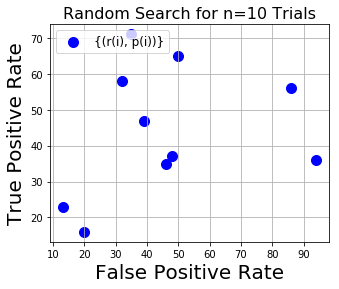

In [389]:
x = range(1)
y = range(1)
fig = plt.figure(figsize=(5, 4))
ax1 = fig.add_subplot(111)

plt.scatter(Rand_E, Rand_M, color='blue', s=100, label=('{(r(i), p(i))}')) 
plt.legend(loc='upper left', fontsize=12);
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Random Search for n=10 Trials', fontsize=16)
plt.grid()

Now we have our randomly distributed values for our first two hyperparameters, so we can use our chosen values $\lambda1 \epsilon[r(i), r(i+1), ... r(i+10)]$. Similarly, for the other hyperparameter being randomly varied and tested, we have $\lambda2 \epsilon[p(i), p(i+1), ... p(i+10)]$. Each of the ten pairs $[(r(i), p(i)), (r(i+1), p(i+1)), ... (r(n), p(n))]$ will be used to train the network, and the resulting model will then be tested using several metrics, and subsequently retrained. (See page 284 in [Random Search for Hyper-Parameter Optimization](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)). 

In [399]:
n = Rand_E.shape[0] #Get length of hyperparameter distrobution vector 

accuracy_save = np.zeros(n)
F1_save = np.zeros(n)

for i in range(n): 
    print("------------------- n = ", i, "-------------------")
    print("Epochs: ", Rand_E[i], "with minibatch size: ", Rand_M[i])
    
    #Define Model
    model = Mushroom_Net() #<-- Use the model created above 
    
    #Declare new parameters 
    training_epochs = Rand_E[i]
    minibatch_size = Rand_M[i]

    #Train Network 
    for j in range(training_epochs):
        for batch_ind in range(10):
            # wrap the data in variables
            minibatch_state_var = Variable(torch.Tensor(X_train))
            minibatch_label_var = Variable(torch.Tensor(y_train))
            # forward pass
            y_pred = model(minibatch_state_var)
            # compute loss as the difference between the prediction and the true label 
            loss = loss_fn(y_pred, minibatch_label_var)
            # now that the forward pass is done, we need to reset all gradients
            optimizer.zero_grad()
            # backwards pass
            loss.backward()
            # step the optimizer - update the weights
            optimizer.step()

    
    #Evaluate model performance
    input_1 = Variable(torch.Tensor(X_test))
    pred_1 = model(input_1)
    pred_1_np = pred_1.detach().numpy()
    y_pred = np.where(pred_1_np>0.5,1,0) #Convert to binary
    y_true = y_test
    A = accuracy_score(y_true, y_pred)
    F1 = f1_score(y_true, y_pred)
    
    #Store evaluation information outside loop 
    accuracy_save[i] = A
    F1_save[i] = F1
  

------------------- n =  0 -------------------
Epochs:  39 with minibatch size:  47
------------------- n =  1 -------------------
Epochs:  35 with minibatch size:  71
------------------- n =  2 -------------------
Epochs:  32 with minibatch size:  58
------------------- n =  3 -------------------
Epochs:  20 with minibatch size:  16
------------------- n =  4 -------------------
Epochs:  13 with minibatch size:  23
------------------- n =  5 -------------------
Epochs:  86 with minibatch size:  56
------------------- n =  6 -------------------
Epochs:  50 with minibatch size:  65
------------------- n =  7 -------------------
Epochs:  48 with minibatch size:  37
------------------- n =  8 -------------------
Epochs:  94 with minibatch size:  36
------------------- n =  9 -------------------
Epochs:  46 with minibatch size:  35


/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([5686])) that is different to the input size (torch.Size([5686, 1])) is deprecated. Please ensure they have the same size.
  # DeprecationWarning is ignored by default
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [400]:
print(accuracy_save)
print(F1_save)

[0.51558655 0.48441345 0.48441345 0.51558655 0.48441345 0.51558655
 0.49589828 0.51558655 0.55086136 0.51558655]
[0.         0.65266648 0.65266648 0.         0.65266648 0.
 0.65525947 0.         0.66988242 0.        ]


We can now find the point $(r(i), p(i))$ which maximizes both accuracy and F1 score. If training time was'nt a problem, we could also increase $n$ in order to make the random search more fine. 

This process could not only be repreated with other parameters, but after finding the right "zone" of highest performance for a certain parameter, we could shrink the upper and lower bounds of the distrobution around that section and run the optomizer again. By repeating this process once or twice, we are making sure we've thouroughly explored the area which yeilds the best model output. 

# Other Regularization Techniques

------

There are many other regularization techniques used to boost model performance and limit the negative effects of overfitting. Some of the more popular techniques are: 

1. L1 Regularization
2. L2 Regularization
3. Dropout Layers
4. Early Stopping

## L1 Regularization 
Both L1 and L2 regularization are methods used to prevent overfitting your model to the dataset. There is only a small difference between the two: the penalty term in the regression. The L1 regularization technique uses "Lasso Regression" [Towards Data Science](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c) which "adds absolute value of magnitude of coefficient as penalty term to the loss function." This simply means that instead of squaring the error in the loss function, we take the absolutie value of the difference. 


## L2 Regularization 
Similar to L1 regularization, L2 regularization is used to prevent overfitting the model to the data. The L2 model uses Ridge Regression, which "adds squared magnitude of coefficient as penalty term to the loss function."[Towards Data Science](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c) This means that, as opposed to L1 regularization, here we square the difference to calculate the error in the loss function. 

## Dropout Layers 
Often used in conjunction with techniques such as L1 and L2 regularization, using dropout layers is a regularization technique used to prevent overfitting. Dropout layers force certain layers to "drop" neurons randomly with some set probabilit $p$ so that the network cannot rely on any certain set of neurons for success. Dropout layers force the network to continually re-learn from the training data; when the training is finished the the network will be used for prediction, the dropout layers are deactivated. 

## Early Stopping
Early stopping can be used when too many epochs have been used to train a network, and the model is fitting the data too closely. Similar to the above regularization methods, early stopping can be used to mitigate the negative effects of overfitting. By plotting the training and testing accuracy and loss, we can determine when the testing loss stops decreasing, and actually brgins increasing. We take the minimum testing loss value, determine the epoch which corresponds to that value, and redefine and retrain the network using that many epochs. 


Sources: <br>
[L1 and L2 Regularization Methods - Towards Data Science](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c)

[Leonardo Araujo Santos - GitBooks.io](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/dropout_layer.html)

[Machine Learning Mastery](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)


# Closing Remarks: AutoKeras

-----

Lastly, it's important to note that Google's AutoML has recently been recreated by Keras in an open source version of a similar software called [AutoKeras.](https://autokeras.com/) 

AutoKeras is a way of finding the best network parameters for the data system at hand without needing to do any parameter optimization using manual search, grid search, random search, or otherwise. 

As we start to see more of these libraries released for free, it will be important to stay up to date on the best libraries which will provide a "stress free" parameter optimization and regularization experience. Still, it's always good to know the best practices for manual regularization both for benchmarking your own models and so that you can be sure libraries such as AutoKeras are performing better than simpler methods such as those discussed above. 